### Train

In [ ]:
#knn_n: 5,
#knn_n: 10

python train_psc.py \
    --data-path ../data/Sketchy \
    --csv-path ../data/PSC6K \
    --save-dir ./checkpoints \
    --log-dir ./checkpoints \
    --resume ./weights/psc_resnet18.pth.tar  \ #pretrained_model
    --task both \
    --arch resnet18 \
    --lr 0.003 \
    --knn-freq 1 --pck-freq 1 \
    --sim-loss 0.1 --con-loss 1.0 -j 16 \
    --epochs 10 \
    --workers 1 \
    --save-freq 1
    
========== Epoch 2511 pck@0.1: 0.822970 ==========
========== Epoch 2511 pck@0.05: 0.541640 ==========

### environment

In [1]:
conda create -n psc python=3.9 -y
conda activate psc
conda install pytorch==1.13.0 torchvision==0.14.0 torchaudio==0.13.0 pytorch-cuda=11.6 -c pytorch -c nvidia

conda install pandas matplotlib seaborn
conda install -c conda-forge tqdm scikit-learn
pip install kornia tensorboard opencv-python-headless

SyntaxError: invalid syntax (2237901637.py, line 1)

### evaluation

In [ ]:
# example: evaluating the trained model
CUDA_VISIBLE_DEVICES=3 python eval.py \
    --data-path ../data/Sketchy \
    --csv-path ../data/PSC6K \
    --arch resnet18 \
    --checkpoint ./checkpoints/{saved_dir_name}/{saved_wt_name}.pth.tar

### Visualize

In [63]:
def visualize_warp(photo, sketch, photo_kps, sketch_kps, save_path=None):
    # 이미지와 키포인트 준비

    print(photo.shape)
    print(sketch.shape)
    
    unnorm_photo = photo.permute(0, 2, 3, 1) * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    unnorm_sketch = sketch.permute(0, 2, 3, 1) * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    unnorm_photo = unnorm_photo.permute(0, 3, 1, 2)
    unnorm_sketch = unnorm_sketch.permute(0, 3, 1, 2)

    photo_np = unnorm_photo.cpu()[0].permute(1, 2, 0).numpy() * 255
    sketch_np = unnorm_sketch.cpu()[0].permute(1, 2, 0).numpy() * 255

    # photo_kps = photo_kps.squeeze(0)
    # sktech_kps = sketch_kps.squeeze(0)

    xa = photo_kps[:, 1]
    ya = photo_kps[:, 0]
    xb = sketch_kps[:, 1]
    yb = sketch_kps[:, 0]

    xa = [int(round(float(x))) for x in xa]
    xb = [int(round(float(x))) for x in xb]
    ya = [int(round(float(x))) for x in ya]
    yb = [int(round(float(x))) for x in yb]

    # 이미지 워핑
    flow = np.zeros((256, 256, 2))
    for j in range(len(xa)):
        flow[ya[j], xa[j], 0] = xb[j] - xa[j]
        flow[ya[j], xa[j], 1] = yb[j] - ya[j]

    # 시각화
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    canvas = np.zeros((256, 256 * 2, 3), dtype=np.uint8)
    canvas[:, :256] = photo_np.astype(np.uint8)
    canvas[:, 256:] = sketch_np.astype(np.uint8)

    for j in range(len(xa)):
        canvas = cv2.line(canvas, (xa[j], ya[j]), (xb[j] + 256, yb[j]), color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
        canvas = cv2.circle(canvas, (xa[j], ya[j]), radius=2, color=(255, 0, 0), thickness=-1)
        canvas = cv2.circle(canvas, (xb[j] + 256, yb[j]), radius=3, color=(255, 0, 0), thickness=-1, lineType=cv2.LINE_AA)

    ax.imshow(canvas)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

Dataset loaded.
Model loaded.
80
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


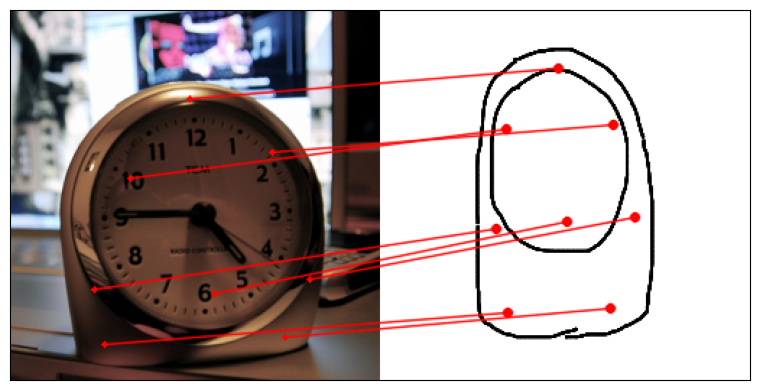

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


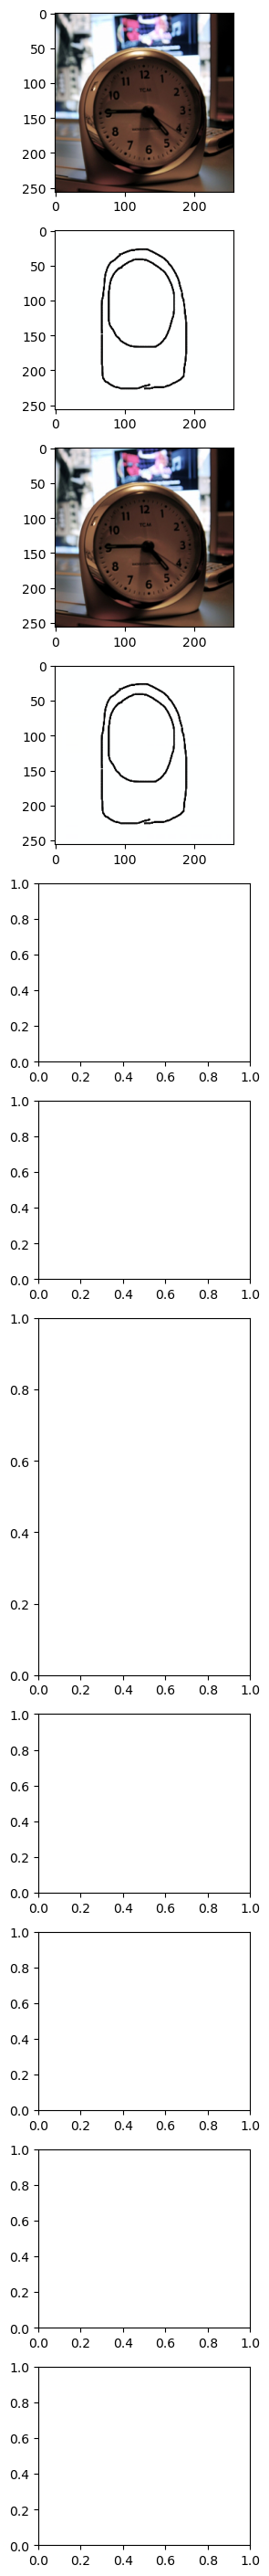

In [141]:
import argparse
import os
import numpy as np

import torch
import torch.nn.functional as F

import models.resnet_cbn as resnet_cbn
import models.resnet_orig as resnet_orig
import models.moco as moco

from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets.photo_sketch_dataset import PhotoSketchDataset
from models.PSCNet import PSCNet
from utils.pck import proj_kps, compute_pck

#########

data_path = '/userHome/userhome1/sojeong/psc/Sketchy'
csv_path = '/userHome/userhome1/sojeong/psc/PSC6K'
arch = 'resnet18'
checkpoint = '/userHome/userhome1/sojeong/psc/0526_pt/moco_imagenet_resnet18_reformat.pth.tar'
layer = [2, 3]
cbn=True

# pick a class below
category = "raccoon"
category_names=['airplane', 'alarm', 'ant','ape', 'apple', 'armor', 'axe', 'banana', 'bat', 'bear', 'bee', 'beetle', 'bell', 'bench', 
                'bicycle', 'blimp', 'bread', 'butterfly', 'cabin', 'camel','candle', 'cannon', 'car','castle', 'cat', 'chair', 'chicken', 
                'church', 'couch', 'cow', 'crab', 'crocodilian', 'cup', 'deer', 'dog', 'dolphin', 'door', 'duck', 'elephant', 'eyeglasses', 
                'fan', 'fish', 'flower', 'frog', 'geyser', 'giraffe', 'guitar', 'hamburger', 'hammer', 'harp', 'hat', 'hedgehog', 'helicopter', 
                'hermit', 'horse', 'hot-air', 'hotdog', 'hourglass', 'jack-o-lantern', 'jellyfish', 'kangaroo', 'knife', 'lion', 'lizard', 
                'lobster', 'motorcycle', 'mouse', 'mushroom', 'owl', 'parrot', 'pear', 'penguin', 'piano', 'pickup', 'pig', 'pineapple', 
                'pistol', 'pizza', 'pretzel', 'rabbit', 'raccoon', 'racket', 'ray', 'rhinoceros', 'rifle', 'rocket', 'sailboat', 'saw', 
                'saxophone', 'scissors', 'scorpion', 'sea', 'seagull', 'seal', 'shark', 'sheep', 'shoe', 'skyscraper', 'snail', 'snake', 
                'songbird', 'spider', 'spoon', 'squirrel', 'starfish', 'strawberry', 'swan', 'sword', 'table', 'tank', 'teapot', 'teddy', 
                'tiger', 'tree', 'trumpet', 'turtle', 'umbrella', 'violin', 'volcano', 'wading', 'wheelchair', 'windmill', 'window', 'wine', 
                'zebra']

category_idx = category_names.index(category)

#########

# Initialization

test_csv = os.path.join(csv_path, "test_pairs_ps.csv")

dataset = PhotoSketchDataset(test_csv, data_path, mode="test")

print("Dataset loaded.")

# import the original or the conditional BN version of ResNet
if cbn:
    resnet = resnet_cbn
else:
    resnet = resnet_orig

model = PSCNet(moco.MoCo, resnet.__dict__[arch], dim=128, K=8192, corr_layer=layer).cuda()

checkpoint = torch.load(checkpoint)
state_dict = checkpoint['state_dict']

for k in list(state_dict.keys()):
    if "module." in k:
        state_dict[k[len("module."):]] = state_dict[k]
        del state_dict[k]

msg = model.load_state_dict(state_dict, strict=False)
# assert len(msg.missing_keys) == 0 and len(msg.unexpected_keys) == 0
model = model.cuda().eval()

print("Model loaded.")

############################
# Computation

image_size = 256
with torch.no_grad():

    num_photo_per_category = 1
    start_idx = category_idx * num_photo_per_category
    step_size = 1

    for i in range(start_idx, start_idx + num_photo_per_category, step_size):
        print(i)
        # load sample
        data = dataset[i]
        photo, sketch, photo_kps, sketch_kps = data
        
        photo = photo.unsqueeze(0)
        sketch = sketch.unsqueeze(0)

        visualize_warp(photo, sketch, photo_kps, sketch_kps)

        photo = photo.cuda(non_blocking=True)
        sketch = sketch.cuda(non_blocking=True)

        mem = return_mem(model, photo, sketch)
        show_graph(mem)
        
        
        break
        ######
        ######2. pred point
        # print(photo.shape)
        # print(sketch.shape)
        

        # get feature maps
        _, photo_res = model.encoder_q(photo, cond=0, return_map=True)
        _, sketch_res = model.encoder_q(sketch, cond=1, return_map=True)

        # estimate displacement field
        fwd_flow, bwd_flow = model.forward_stn(photo_res, sketch_res)
        # fwd_flow, bwd_flow = fwd_flow.cpu(), bwd_flow.cpu()
        # torch.Size([1, 16, 16, 2])
        
        fwd_flow = F.interpolate(fwd_flow.permute(0, 3, 1, 2), (image_size, image_size),
                                 mode="bilinear", align_corners=True).permute(0, 2, 3, 1).cpu()
        bwd_flow = F.interpolate(bwd_flow.permute(0, 3, 1, 2), (image_size, image_size),
                                 mode="bilinear", align_corners=True).permute(0, 2, 3, 1).cpu()
        # print(fwd_flow.shape)
        # print(bwd_flow.shape)
        # torch.Size([1, 256, 256, 2])
        
        photo_kps = torch.tensor(photo_kps).unsqueeze(0).cpu()
        sketch_kps = torch.tensor(sketch_kps).unsqueeze(0).cpu()
        
        print(photo_kps.shape)
        print(sketch_kps.shape)
        # torch.Size([1, 8, 2])
        
        # project keypoints & compute error
        pred_sketch_kps = proj_kps(bwd_flow, photo_kps, image_size)
        pred_photo_kps = proj_kps(fwd_flow, sketch_kps, image_size)

        #### 1.point visualize
        # #cpu device
        # photo = photo.cpu()
        # sketch = sketch.cpu()
        # pred_photo_kps = pred_photo_kps.cpu()
        # pred_sketch_kps = pred_sketch_kps.cpu()

        # photo_kps = photo_kps.squeeze(0)
        # sketch_kps = sketch_kps.squeeze(0)
        # pred_photo_kps = pred_photo_kps.squeeze(0)
        # pred_sketch_kps = pred_sketch_kps.squeeze(0)
        
        # visualize_warp(photo, sketch, pred_sketch_kps, pred_photo_kps)


        # #### 2. image warping
        # # render warped cross modal image
        # cross_fwd_flow_large = F.interpolate(cross_fwd_flow.permute(0, 3, 1, 2),
        #                                         (data[0].shape[-1], data[0].shape[-1]),
        #                                         mode="bilinear",
        #                                         align_corners=True).permute(0, 2, 3, 1)
        # cross_bwd_flow_large = F.interpolate(cross_bwd_flow.permute(0, 3, 1, 2),
        #                                         (data[0].shape[-1], data[0].shape[-1]),
        #                                         mode="bilinear",
        #                                         align_corners=True).permute(0, 2, 3, 1)

        # warped_img_src = F.grid_sample(photo, cross_fwd_flow_large, mode="bilinear",
        #                                 padding_mode="border",
        #                                 align_corners=True)
        # warped_img_dst = F.grid_sample(sketch, cross_bwd_flow_large, mode="bilinear",
        #                                 padding_mode="border",
        #                                 align_corners=True)

        break




In [140]:
import utils
from utils.visualization import gen_graph, prep_img_tensor, prep_feat_tensor
from models.PSCNet import mask_outlier
from utils.spatial_transforms import SynthecticAffHomoTPSTransfo
import torch.nn as nn
import kornia.augmentation as aug

syn_flow_gen = SynthecticAffHomoTPSTransfo(random_t=1 / 2, random_alpha=np.pi / 8, random_t_tps=1 / 4,
                                            tps_grid_size=4,
                                            random_s=(0.5, 1.5), tps_reg_factor=0.0, random_t_tps_for_afftps=1 / 4,
                                            size_output_flow=(256, 256), flip=False,
                                            #transformation_types=args.trans_type,
                                            use_cuda=True)
color_aug = nn.Sequential(
        aug.ColorJitter(0.4, 0.4, 0.4, 0.1),
        aug.RandomGrayscale(p=0.2),
        aug.RandomGaussianBlur((13, 13), (0.1, 2.0), p=0.5),
        aug.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    )


def return_mem(model, photo, sketch):
    mem = {
        "image1": [],
        "image2": [],
        "warp_image12": [],
        "warp_image21": [],
        "res2_1": [],
        "res2_2": [],
        "res3_1": [],
        "res3_2": [],
        "weight3_1": [],
        "weight3_2": [],
        "dist": []
    }
    
    images1 = photo
    images2 = sketch

    images1 = images1.cuda()
    images2 = images2.cuda()
    images1_raw = images1.clone()
    cond_src = 0  # photo
    cond_dst = 1  # sketch
    
    img_src_aug = color_aug(images1)
    img_dst_aug = color_aug(images2)
    img_src_raw = color_aug(images1_raw)

    # generate synthetic flows
    syn_gt_flow_src = torch.cat([mask_outlier(syn_flow_gen()) for _ in range(len(images1))], dim=0)
    syn_gt_flow_dst = torch.cat([mask_outlier(syn_flow_gen()) for _ in range(len(images1))], dim=0)

    img_src_aug = F.grid_sample(img_src_aug,
                                syn_gt_flow_src,
                                mode="bilinear", padding_mode="border", align_corners=True)
    img_dst_aug = F.grid_sample(img_dst_aug,
                                syn_gt_flow_dst,
                                mode="bilinear", padding_mode="border", align_corners=True)

    _, feat_dst_aug = model.forward_backbone(img_dst_aug, cond_dst, corr_only=True)
    _, feat_src_aug = model.forward_backbone(img_src_aug, cond_src, corr_only=True)
    with torch.no_grad():
        _, feat_src_raw = model.forward_backbone(img_src_raw, cond_src, corr_only=True)

    # compute cross-modal warp: src_raw -> dst_aug
    fwd_flow, bwd_flow, dist = model.forward_stn(feat_src_raw, feat_dst_aug, dense_mtx=True)

    # collect image features
    # fc1, res1 = model.forward_backbone(images1, cond=0)
    # fc2, res2 = model.forward_backbone(images2, cond=1)

    # features1.append(fc1.detach().cpu().numpy())
    # features2.append(fc2.detach().cpu().numpy())

    # collect examples of warping
    #fwd_flow, bwd_flow, dist = model.forward_stn(res1, res2, dense_mtx=True)
    fwd_flow = F.interpolate(fwd_flow.permute(0, 3, 1, 2), (256, 256), mode="bilinear",
                            align_corners=True).permute(0, 2, 3, 1)
    bwd_flow = F.interpolate(bwd_flow.permute(0, 3, 1, 2), (256, 256), mode="bilinear",
                            align_corners=True).permute(0, 2, 3, 1)

    # visualize examples of warping
    mem["image1"].append(prep_img_tensor(images1))
    mem["image2"].append(prep_img_tensor(images2))
    warped_images12 = F.grid_sample(images1, fwd_flow, mode="bilinear", padding_mode="zeros",
                                    align_corners=True)
    warped_images21 = F.grid_sample(images2, bwd_flow, mode="bilinear", padding_mode="zeros",
                                    align_corners=True)
    mem["warp_image12"].append(prep_img_tensor(warped_images12))
    mem["warp_image21"].append(prep_img_tensor(warped_images21))
    mem["res2_1"].append(prep_feat_tensor(res1["layer2"]))
    mem["res2_2"].append(prep_feat_tensor(res2["layer2"]))
    mem["res3_1"].append(prep_feat_tensor(res1["layer3"]))
    mem["res3_2"].append(prep_feat_tensor(res2["layer3"]))
    mem["weight3_1"].append(None)
    mem["weight3_2"].append(None)
    mem["dist"].append(dist[0].detach().cpu().numpy().view())
    
    return mem


In [126]:
def show_graph(mem):

    fig, axes = plt.subplots(11, len(mem["image1"]),
                                figsize=(len(mem["image1"]) * 3, 12 * 3),
                                gridspec_kw={'height_ratios': [1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,]})
    axes = axes.reshape(-1, 1)
    for idx in range(len(mem["image1"])):
        axes[0, idx].imshow(mem["image1"][idx])
        axes[1, idx].imshow(mem["image2"][idx])

        axes[2, idx].imshow(mem["warp_image12"][idx])
        axes[3, idx].imshow(mem["warp_image21"][idx])

        if mem["weight3_1"][idx] is not None:
            img_size = mem["warp_image12"][idx].shape[0]
            axes[4, idx].imshow(F.interpolate(mem["weight3_1"][idx].unsqueeze(0).unsqueeze(0),
                                                (img_size, img_size), mode="bilinear")[0, 0])
            axes[5, idx].imshow(F.interpolate(mem["weight3_2"][idx].unsqueeze(0).unsqueeze(0),
                                                (img_size, img_size), mode="bilinear")[0, 0])

    # if mem["dist"][idx] is not None:
    #     corr = _vis_corr(mem["dist"][idx],
    #                     mem["image1"][idx], mem["image2"][idx])
    #     axes[6, idx].imshow(corr)

    # map1, map2 = _vis_map([mem["res2_1"][idx], mem["res2_2"][idx]])
    # axes[7, idx].imshow(map1)
    # axes[8, idx].imshow(map2)

    # map1, map2 = _vis_map([mem["res3_1"][idx], mem["res3_2"][idx]])
    # axes[9, idx].imshow(map1)
    # axes[10, idx].imshow(map2)

    return fig